In [20]:
using DiffusionMLE, Plots, CSV, DataFrames

# Introduction

This is a minimal example on how to apply our maximum likelihood estimator to a set of heterogeneous single-particle tracking data.  Here, "heterogeneous" refers to the fact that the data originate from subpopulations with differing diffusion coefficients.  

The code relevant for the analysis of heterogeneous data exploits threading, so it is recommended to run the command <code>export JULIA_NUM_THREADS=n</code>, with <code>n</code> being the number of available (physical) cores, before launching Julia.  This speeds up the numerics significantly.  

For more details on the theoretical framework, please refer to the associated preprint:
> J. T. Bullerjahn and G. Hummer, "Maximum likelihood estimates of diffusion coefficients from single-molecule tracking experiments", https://arxiv.org/abs/2011.09955

# Generate trajectories

Each trajectory can be seen as a $d$-dimensional array (<code>Array{Float64,2}</code>), so the data set should be of the type <code>Array{Array{Float64,2},1}</code>.  

Here, we generate mock data, made up of $M$ $d$-dimensional trajectories of different lengths $N = \{N_{1}, N_{2}, \dots, N_{M}\}$.  The $N_{i}$ are distributed uniformly on the interval $[3,100]$.  The data form a $3:4:3$-mixture of trajectories generated using three distinct diffusive dynamics.  

In [21]:
include("smeared_trajectory_integrator.jl")

const M = 1000 # Number of trajectories
const d = 2 # Dimension of trajectories

const N_sub = 100 # Number of substeps over which the trajectory is smeared out

N = [ rand(3:100) for i = 1 : M ] # Array of trajectory lengths

# Consider three subpopulations, characterized by the following parameters:
const a2_1 = 0.5
const a2_2 = 2.0
const a2_3 = 1.0
const σ2_1 = 0.1
const σ2_2 = 1.0
const σ2_3 = 10.0

B = [1/6 for m = 1 : M] # Array of blurring coefficients, where we have assumed a uniform illumination profile
data = vcat([make_2D_data(N[1:300],N_sub,a2_1,σ2_1), 
        make_2D_data(N[301:700],N_sub,a2_2,σ2_2), 
        make_2D_data(N[701:1000],N_sub,a2_3,σ2_3)]...); # Mock data set

# Analyzing the data

In [22]:
function print_results(estimates,uncertainties)
    K = size(estimates,2)
    for k = 1 : K
        println(string("a2_", k, " = ", estimates[1,k], " ± ", uncertainties[1,k]))
    end
    for k = 1 : K
        println(string("σ2_", k, " = ", estimates[2,k], " ± ", uncertainties[2,k]))
    end
    for k = 1 : K
        println(string("P_", k, " = ", estimates[3,k]))
    end
end

const N_local = 1000 # Max number of expectation-maximization cycles
const N_global = 200 # Number of iterations with different initial parameters

# Ranges from which the initial values for the parameters are drawn:
a2_range = [ 0.000001, 1000. ]
σ2_range = [ 0.000001, 1000. ];

### Available cores for threading

In [23]:
using Base.Threads
println(string("Number of available cores for threading: ", nthreads()))

Number of available cores for threading: 1


### Assuming a single population

Estimates:
a2_1 = 1.2365709754120182 ± 0.016184639293340002
σ2_1 = 3.5610402877518372 ± 0.027553670100033806
P_1 = 1.0

Kuiper statistic:
κ = 24.2792572582363


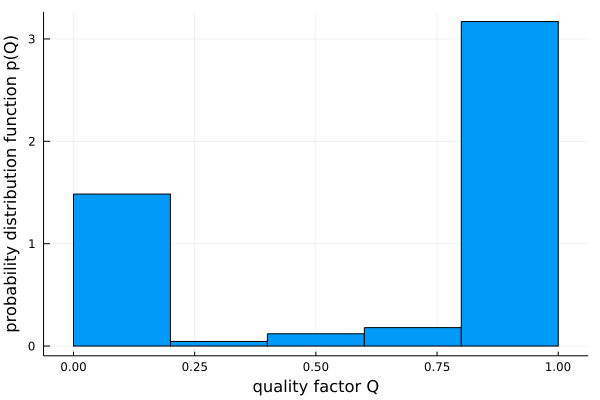


(process:14172): GLib-GIO-WARNING **: 13:21:09.437: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.1900.3.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


In [24]:
parameters = MLE_estimator(B,data)
parameter_matrix = reshape(vcat([parameters,[1.0]]...), 3, 1)
P1_estimates, P1_L, P1_T = local_EM_estimator!(d,M,1,N_local,parameter_matrix,B,data)
P1_uncertainties = MLE_errors(B,data,parameters)

println("Estimates:")
print_results(P1_estimates,P1_uncertainties)

Q_sub = subpopulation_analysis(P1_T,P1_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("κ = ",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, 
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The distribution of quality factors, which should be uniform, and the associated Kuiper statistic reveal that a single-population model does not suffice.  

### Assuming two subpopulations

In [25]:
P2_estimates, P2_L, P2_T = global_EM_estimator(2,N_local,N_global,a2_range,σ2_range,B,data);

Progress:   5%|███                                      |  ETA: 0:02:46┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress:   6%|███                                      |  ETA: 0:02:28┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress:  10%|████                                     |  ETA: 0:02:13┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress:  12%|██████                                   |  ETA: 0:02:04┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress:  20%|█████████  

In [27]:
P2_T

2×1000 Matrix{Float64}:
 1.0         1.0          1.0         …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.0316e-53  2.21811e-61  2.6169e-45     1.0  1.0  1.0  1.0  1.0  1.0  1.0

Estimates:
a2_1 = 0.4974244360379482 ± 0.005352920775125211
a2_2 = 1.5676494304191422 ± 0.026309624440930827
σ2_1 = 0.10144781725247431 ± 0.0022509413728280725
σ2_2 = 5.102432367381601 ± 0.04681802807571272
P_1 = 0.3039174570153468
P_2 = 0.6960825429846533

Kuiper statistic:
K=17.67955114585654


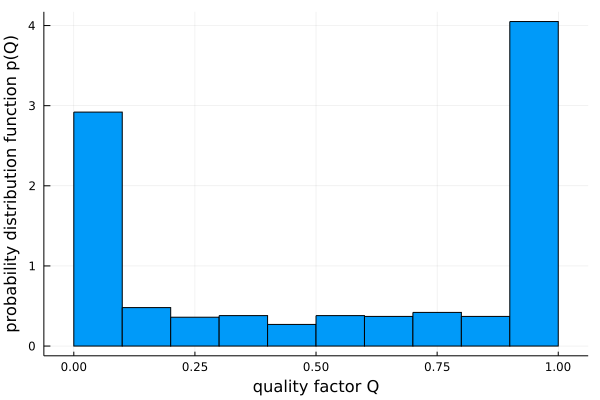

In [26]:
B_sub, X_sub = sort_trajectories(2,P2_T,B,data)
P2_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P2_estimates[1:2,k]) for k = 1 : 2 ]...)

println("Estimates:")
print_results(P2_estimates,P2_uncertainties)

Q_sub = subpopulation_analysis(P2_T,P2_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, bins=10,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The Kuiper statistic is slightly better, but overall a two-population model cannot explain the data.  

### Assuming three subpopulations

In [8]:
P3_estimates, P3_L, P3_T = global_EM_estimator(3,N_local,N_global,a2_range,σ2_range,B,data);

Progress:   2%|██                                       |  ETA: 0:16:51

In [ ]:
B_sub, X_sub = sort_trajectories(3,P3_T,B,data)
P3_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P3_estimates[1:2,k]) for k = 1 : 3 ]...)

println("Estimates:")
print_results(P3_estimates,P3_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P3_T,P3_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The quality factors are uniformly distributed, and the Kuiper statistic evaluates close to unity for the three-population model.  

### Diffusion coefficients

Diffusion coefficients can be extracted from the $\sigma^2$-values, irrespective of the dimension $d$, as follows:
\begin{equation*}
D = \frac{\sigma^2}{2 \Delta t} \, .  
\end{equation*}
Here, $\sigma$ has the same dimension as the data, i.e., if the trajectories are recorded on the nanometer scale then $[\sigma] = \textrm{nm}$, and $\Delta t$ denotes the time step between two observations.  

### Assuming four subpopulations

In [ ]:
P4_estimates, P4_L, P4_T = global_EM_estimator(4,N_local,N_global,a2_range,σ2_range,B,data);

In [ ]:
B_sub, X_sub = sort_trajectories(4,P4_T,B,data)
P4_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P4_estimates[1:2,k]) for k = 1 : 4 ]...)

println("Estimates:")
print_results(P4_estimates,P4_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P4_T,P4_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

# Assuming 5 subpops

In [ ]:
P6_estimates, P6_L, P6_T = global_EM_estimator(6,N_local,N_global,a2_range,σ2_range,B,data);

In [ ]:
B_sub, X_sub = sort_trajectories(5,P5_T,B,data)
P5_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P4_estimates[1:2,k]) for k = 1 : 5 ]...)

println("Estimates:")
print_results(P5_estimates,P5_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P5_T,P5_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

# Below: Upload tdTomato_37Degree Mobile data

In [4]:
function load_traj_csv(raw_csv_file_path)
    csv_data = CSV.read(raw_csv_file_path, DataFrame)
    csv_data = dropmissing(csv_data)
    trackIDs = unique(csv_data, :ID).ID
    trk_count = length(trackIDs)
    B_values = [1/6 for m = 1 : trk_count]
    sing_cond_tracks = Array{Array{Float64,2},1}(undef, trk_count)
    n = 0
    for i in trackIDs
        n += 1
        indiv_track = csv_data[in([i]).(csv_data.ID), :]
        sing_cond_tracks[n] = Array(indiv_track[:, [:X, :Y]])
    end
    return sing_cond_tracks, B_values
end

load_traj_csv (generic function with 1 method)

In [5]:
# Import some test trajectories...
tester = raw"C:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\Trajectory_CSVs\tdTomato_Mobile\tdTomato_37Degree_mobile.csv"
test_data = CSV.read(tester, DataFrame);

# Select just the tracks that have been re-zeroed
test_data = test_data[test_data.ID .< 3000, :]

trackIDs = unique(test_data, :ID).ID;

In [6]:
mob_data, B_values = load_traj_csv(tester);

In [7]:
PX_estimates, PX_L, PX_T = global_EM_estimator(3,N_local,N_global,a2_range,σ2_range,B_values,mob_data);

┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress:   1%|█                                        |  ETA: 0:07:53┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress:   2%|█                                        |  ETA: 0:07:48┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress:   2%|█                                        |  ETA: 0:07:21┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress:   2%|██                                       |  ETA: 0:07:03┌ Warning: NaN detected
└ 

In [8]:
B_sub, X_sub = sort_trajectories(3,PX_T,B_values,mob_data)
PX_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], PX_estimates[1:2,k]) for k = 1 : 3 ]...)

println("Estimates:")
print_results(PX_estimates,PX_uncertainties)

println()

Q_sub = subpopulation_analysis(PX_T,PX_estimates,B_values,mob_data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

LoadError: BoundsError: attempt to access 0-element Vector{Matrix{Float64}} at index [1]

In [13]:
mob_data

3345-element Vector{Matrix{Float64}}:
 [38.03921533198764 91.0106436419909; 38.09617753579804 91.00776183247646; … ; 38.66832991678541 91.03632763906067; 38.671069731886114 91.02072798480471]
 [52.30472173254977 93.76520392993226; 52.27783483328655 93.77576881939284; … ; 52.80411617421224 92.2611833862967; 52.8178544305479 92.20082214711363]
 [58.18545736344977 26.658555290703173; 58.16101127467751 26.60920696440354; … ; 57.71826713595652 25.462453963997746; 57.59620326290387 25.574767335748398]
 [68.02567255279081 55.05453029482074; 68.00926060531117 55.06106059930411; … ; 68.5030866291064 54.31561589602916; 68.5704694825362 54.32097210396887]
 [76.20040871000602 65.1557582450138; 76.15665586216313 65.15185150840257; … ; 76.06187844431993 66.0975418640479; 76.199015022925 66.09986918012656]
 [78.32558785296726 76.38300702927226; 78.31922156488538 76.42961738719461; … ; 76.61759440163108 76.41180164687391; 76.56515461585094 76.67223407285297]
 [78.86439042069273 89.61838701846666; 78.8

In [19]:
data[[1]]

1-element Vector{Matrix{Float64}}:
 [-0.2736163995431172 -0.1051718290530699; 0.6901288696997122 0.3147046597626799; … ; -2.347536267704408 0.055304819967828656; -2.7614535527513286 0.9422712899779128]

In [18]:
mob_data[[1]]

1-element Vector{Matrix{Float64}}:
 [38.03921533198764 91.0106436419909; 38.09617753579804 91.00776183247646; … ; 38.66832991678541 91.03632763906067; 38.671069731886114 91.02072798480471]